In [2]:
# import copy
from collections.abc import Iterable
import functools
import itertools
import operator
from matplotlib import pyplot as plt

import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import math
import random
from pprint import pprint
from scipy.optimize import curve_fit
from scipy.stats import poisson
from scipy.sparse import hstack, vstack, csr_matrix
import scipy

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.preprocessing import Normalizer, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
import joblib

import seaborn as sns

import sys
import os

from config import demographics, vital_sign_vars, lab_vars, treatment_vars, vent_vars, guideline_vars, ffill_windows_clinical, SAMPLE_TIME_H
from config import fio2_bins, peep_bins, tv_bins
import safety
import utils
from utils import to_discrete_action

In [3]:
scalers_dir = '../preprocessing/scalers/'
data_dir = '../mimic-data/'
seed = 12

SHAPING = False
COMPLIANCE_SCALAR = 0.0 # should be in [0, 5]
UNSAFETY_PROB = 1.0 # should be in [0.0,1.0] or {0,0, 1.0} until safety probs implemented
GAMMA = 0.99
n_states = 650 # according to Peine's paper
CREATE_TRAJS = True
if not SHAPING:
    shaping_name = 'unshaped'
else:
    shaping_name = SHAPING + '-' + str(COMPLIANCE_SCALAR )
np.random.seed(seed)
random.seed(seed)
all_var_types = [
    vital_sign_vars,
    lab_vars,
    treatment_vars,
    vent_vars,
    guideline_vars,
]
all_vars = functools.reduce(operator.add, all_var_types)

In [3]:
if CREATE_TRAJS:
    train_set = pd.read_csv(data_dir + 'train_imputed_{}.csv'.format(seed))
    clinical_train_scaler = joblib.load(scalers_dir + 'train/clinical_std_scaler_{}.bin'.format(seed))
    demographics_train_scaler = joblib.load(scalers_dir + 'train/demographics_std_scaler_{}.bin'.format(seed))

    test_set = pd.read_csv(data_dir + 'test_ffilled_{}.csv'.format(seed))
    val_set = pd.read_csv(data_dir + 'validation_ffilled_{}.csv'.format(seed))

    knn_imputer = joblib.load(scalers_dir + 'train/knn_imputer_{}.bin'.format(seed))
    scalers = {}
    for var in all_vars + demographics:
        try:
            scalers[var] = joblib.load(scalers_dir + 'train/{}_std_scaler_{}.bin'.format(var, seed))
        except FileNotFoundError:
            pass

    # TODO: FIX for test and validation sets: scaling (w/ train scaler?), knn imputation (w/ train clusterer), scaling (w/ train scaler?) and clustering (w/ train clusterer)
    # for df in (test_set, val_set):
    #     vars_to_impute = []
    #     for var in all_vars:
    #         if pd.api.types.is_numeric_dtype(df[var]):
    #             ffilled = var + '_imp'
    #             non_nas = df[~df[ffilled].isna()][ffilled].to_numpy().reshape(-1,1)
    #             scaled = scalers[var].transform(non_nas)
    #             scaledvarname = ffilled + '_scaled'
    #             df[scaledvarname] = pd.Series(scaled.reshape(1,-1)[0])
    #             vars_to_impute.append(scaledvarname)
    #     for var in demographics:
    #         if pd.api.types.is_numeric_dtype(df[var]):
    #             non_nas = df[~df[var].isna()][var].to_numpy().reshape(-1, 1)
    #             scaled = scalers[var].transform(df[var].to_numpy().reshape(-1,1))
    #             scaledvarname = var + '_scaled'
    #             df[scaledvarname] = pd.Series(scaled.reshape(1,-1)[0])
    #             vars_to_impute.append(scaledvarname)
    #     knn_imputed_vars = list(map(lambda x: x + '_impknn', vars_to_impute))
    #     imputed = knn_imputer.transform(df[vars_to_impute].to_numpy())
    #     df.loc[:, knn_imputed_vars] = imputed

In [4]:
if CREATE_TRAJS:
    # NOTE: these have not been rescaled after imputation
    test_set.to_csv(data_dir + 'test_imputed_{}.csv'.format(seed))
    val_set.to_csv(data_dir + 'validation_imputed_{}.csv'.format(seed))

In [5]:
if CREATE_TRAJS:
    var_to_state_var = {}
    for var in all_vars + demographics:
        if var not in ('vent_duration_h', 'hospmort', 'mort90day'):
            if var + '_imp_scaled_impknn' in train_set.columns:
                var_to_state_var[var] = var + '_imp_scaled_impknn'
            elif var + '_scaled_impknn' in train_set.columns:
                var_to_state_var[var] = var + '_scaled_impknn'

    # TODO: validate if this contains all vars
    state_variables = list(var_to_state_var.values())

In [6]:
if CREATE_TRAJS:
    longest_sv = max(map(len, state_variables))
    for sv in state_variables:
        print(("{:<" + str(longest_sv) +"}: {:.4f} {:.4f} {:.4f}").format(sv, train_set[sv].mean(), train_set[sv].median(), train_set[sv].var()))

sofa_imp_scaled_impknn              : -0.0129 0.2138 1.0507
sirs_imp_scaled_impknn              : 0.0100 -0.1035 1.0049
gcs_imp_scaled_impknn               : 0.0563 0.1245 1.0387
heartrate_imp_scaled_impknn         : 0.0035 -0.0549 1.0044
sysbp_imp_scaled_impknn             : -0.0285 -0.1591 0.9903
meanbp_imp_scaled_impknn            : -0.0199 -0.1282 0.9873
diasbp_imp_scaled_impknn            : -0.0084 -0.0810 1.0028
shockindex_imp_scaled_impknn        : 0.0158 -0.1089 1.0355
resprate_imp_scaled_impknn          : 0.0370 -0.0878 1.0096
spo2_imp_scaled_impknn              : -0.0635 0.1250 0.9924
tempc_imp_scaled_impknn             : -0.0360 -0.0528 0.9902
potassium_imp_scaled_impknn         : 0.0451 -0.0876 0.9812
sodium_imp_scaled_impknn            : -0.0266 -0.0732 0.9953
chloride_imp_scaled_impknn          : -0.0232 0.0197 1.0103
glucose_imp_scaled_impknn           : 0.0122 -0.1884 1.0248
bun_imp_scaled_impknn               : 0.0793 -0.2459 1.0705
creatinine_imp_scaled_impknn        

In [7]:
if CREATE_TRAJS:
    # NOTE: mirror the changes made here in the 'unscale' logic
    rescaler = StandardScaler()

    rescaled = rescaler.fit_transform(train_set[state_variables])
    rs_state_varnames = [var + '_rescaled' for var in state_variables]
    train_set[rs_state_varnames] = rescaled

    rescaled_test = rescaler.transform(test_set[state_variables])
    test_set[rs_state_varnames] = rescaled_test

In [8]:
if CREATE_TRAJS:
    clusterer = KMeans(n_clusters=n_states)
    train_clusters = clusterer.fit_predict(train_set[rs_state_varnames])
    test_clusters = clusterer.predict(test_set[rs_state_varnames])

c:\Users\hmilab\Anaconda3\envs\VM_RL\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


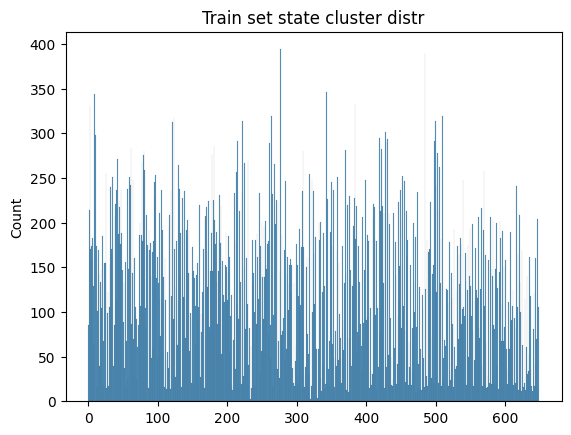

In [9]:
if CREATE_TRAJS:
    sns.histplot(train_clusters, bins=n_states)
    plt.title('Train set state cluster distr')

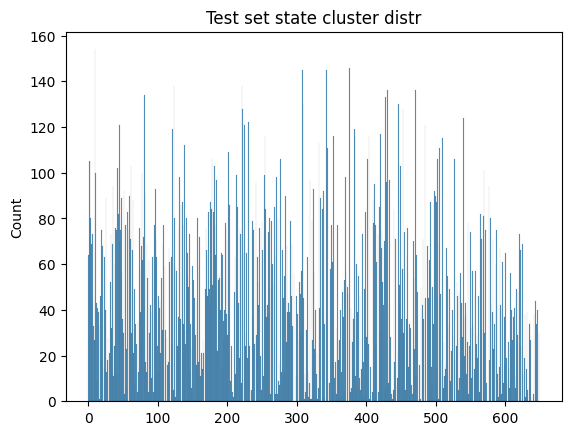

In [10]:
if CREATE_TRAJS:
    sns.histplot(test_clusters, bins=n_states)
    plt.title('Test set state cluster distr')

In [11]:
if CREATE_TRAJS:
    clusters = pd.Series(train_clusters)
    test_clusters_series = pd.Series(test_clusters)
    clusters.value_counts()

In [12]:
if CREATE_TRAJS:
    longest_sv = max(map(len, rs_state_varnames))
    for sv in rs_state_varnames:
        print(("{:<" + str(longest_sv) +"}: {:.4f} {:.4f} {:.4f}").format(sv, train_set[sv].mean(), train_set[sv].median(), train_set[sv].var()))

sofa_imp_scaled_impknn_rescaled              : 0.0000 0.2213 1.0000
sirs_imp_scaled_impknn_rescaled              : -0.0000 -0.1133 1.0000
gcs_imp_scaled_impknn_rescaled               : -0.0000 0.0669 1.0000
heartrate_imp_scaled_impknn_rescaled         : -0.0000 -0.0583 1.0000
sysbp_imp_scaled_impknn_rescaled             : 0.0000 -0.1312 1.0000
meanbp_imp_scaled_impknn_rescaled            : 0.0000 -0.1091 1.0000
diasbp_imp_scaled_impknn_rescaled            : -0.0000 -0.0725 1.0000
shockindex_imp_scaled_impknn_rescaled        : -0.0000 -0.1225 1.0000
resprate_imp_scaled_impknn_rescaled          : -0.0000 -0.1242 1.0000
spo2_imp_scaled_impknn_rescaled              : 0.0000 0.1893 1.0000
tempc_imp_scaled_impknn_rescaled             : 0.0000 -0.0169 1.0000
potassium_imp_scaled_impknn_rescaled         : -0.0000 -0.1340 1.0000
sodium_imp_scaled_impknn_rescaled            : -0.0000 -0.0467 1.0000
chloride_imp_scaled_impknn_rescaled          : 0.0000 0.0427 1.0000
glucose_imp_scaled_impknn_resc

In [13]:
if CREATE_TRAJS:
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(train_set[rs_state_varnames])

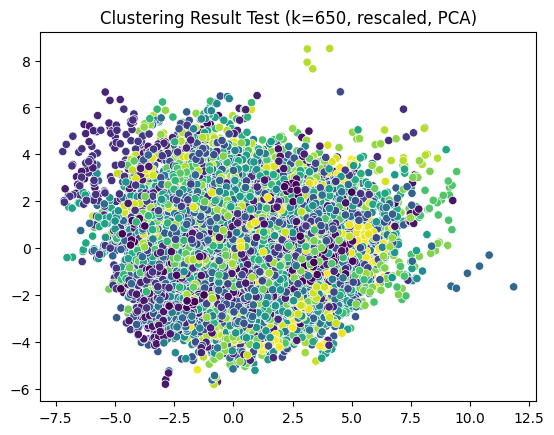

In [14]:
if CREATE_TRAJS:
    #pca = PCA(n_components=2)
    #pca_result = pca.fit_transform(test_set[rs_state_varnames])
    pca_result = pca.transform(test_set[rs_state_varnames])
    sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], c=test_clusters)
    plt.title('Clustering Result Test (k={}, rescaled, PCA)'.format(n_states))

In [15]:
if CREATE_TRAJS:
    print("""silhouette: {}, [-1, 1], higher is better
    calinksi-harabasz: {}, higher is better
    davies-bouldin: {}, [0, ∞], lower is better""".format(
        metrics.silhouette_score(train_set[rs_state_varnames], train_clusters),
        metrics.calinski_harabasz_score(train_set[rs_state_varnames], train_clusters),
        metrics.davies_bouldin_score(train_set[rs_state_varnames], train_clusters)))

silhouette: 0.05322685409604957, [-1, 1], higher is better
    calinksi-harabasz: 153.60375832112842, higher is better
    davies-bouldin: 2.3378949735321073, [0, ∞], lower is better


In [16]:
if CREATE_TRAJS:
    train_set['state'] = clusters
    test_set['state'] = test_clusters_series

# Unscale - back to original and interpretable space

In [17]:
if CREATE_TRAJS:
    # This step is spurious for now, as there is no imputation after rescaling
    un_rescaled_state_vars = rescaler.inverse_transform(train_set[rs_state_varnames])
    un_rescaled_state_vars_test = rescaler.inverse_transform(test_set[rs_state_varnames])

    clinical_scaled_varnames = [var + '_impknn' for var in joblib.load('../preprocessing/scalers/train/clinical_std_varnames_{}.bin'.format(seed))]
    demographics_scaled_varnames = [var + '_impknn' for var in joblib.load('../preprocessing/scalers/train/demographics_std_varnames_{}.bin'.format(seed))]
    unscaled_clinical_vars = clinical_train_scaler.inverse_transform(train_set[clinical_scaled_varnames])
    unscaled_clinical_vars_test = clinical_train_scaler.inverse_transform(test_set[clinical_scaled_varnames])
    unscaled_demo_vars = demographics_train_scaler.inverse_transform(train_set[demographics_scaled_varnames])
    unscaled_demo_vars_test = demographics_train_scaler.inverse_transform(test_set[demographics_scaled_varnames])


    unscaled_clinical_varnames = [var + '_unscaled' for var in clinical_scaled_varnames]
    unscaled_demographics_varnames = [var + '_unscaled' for var in demographics_scaled_varnames]
    train_set[unscaled_clinical_varnames] = unscaled_clinical_vars
    test_set[unscaled_clinical_varnames] = unscaled_clinical_vars_test
    train_set[unscaled_demographics_varnames] = unscaled_demo_vars
    test_set[unscaled_demographics_varnames] = unscaled_demo_vars_test

C:\Users\hmilab\AppData\Local\Temp\ipykernel_15500\3399159209.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_set[unscaled_demographics_varnames] = unscaled_demo_vars
C:\Users\hmilab\AppData\Local\Temp\ipykernel_15500\3399159209.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_set[unscaled_demographics_varnames] = unscaled_demo_vars
C:\Users\hmilab\AppData\Local\Temp\ipykernel_15500\3399159209.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

In [18]:
if CREATE_TRAJS:
    # validation unscaling
    #  * does not introduce NaNs
    #  * does not change known values (by some error margin)
    clinical_varname_pairs = list(zip(unscaled_clinical_varnames, map(lambda x: x.replace("_imp_scaled_impknn", ""), clinical_scaled_varnames)))
    demo_varname_pairs = list(zip(unscaled_demographics_varnames, map(lambda x: x.replace("_scaled_impknn", ""), demographics_scaled_varnames)))
    all_varname_pairs = clinical_varname_pairs + demo_varname_pairs
    for (unscaled, original) in all_varname_pairs:
        print(unscaled, original)
        # check that the number of NaNs for unscaled is less or equal than original
        assert train_set[unscaled].isna().sum() <= train_set[original].isna().sum(), "Unscaling has introduced NaNs in train set"
        assert test_set[unscaled].isna().sum() <= test_set[original].isna().sum(), "Unscaling has introduced NaNs in test set"
        # calculate difference between unscaled and original value
        difference = np.absolute(train_set[~train_set[unscaled].isna()][unscaled] - train_set[~train_set[unscaled].isna()][original])
        difference_test = np.absolute(test_set[~test_set[unscaled].isna()][unscaled] - test_set[~test_set[unscaled].isna()][original])
        # difference should be small OR the original should be NaN.
        assert ((difference < 0.0001) | train_set[~train_set[unscaled].isna()][original].isna()).all(), "Unscaling introduced errors for variable '{}' in train set".format(original)
        assert ((difference_test < 0.0001) | test_set[~test_set[unscaled].isna()][original].isna()).all(), "Unscaling introduced errors for variable '{}' in test set".format(original)

sofa_imp_scaled_impknn_unscaled sofa
sirs_imp_scaled_impknn_unscaled sirs
gcs_imp_scaled_impknn_unscaled gcs
heartrate_imp_scaled_impknn_unscaled heartrate
sysbp_imp_scaled_impknn_unscaled sysbp
meanbp_imp_scaled_impknn_unscaled meanbp
diasbp_imp_scaled_impknn_unscaled diasbp
shockindex_imp_scaled_impknn_unscaled shockindex
resprate_imp_scaled_impknn_unscaled resprate
spo2_imp_scaled_impknn_unscaled spo2
tempc_imp_scaled_impknn_unscaled tempc
potassium_imp_scaled_impknn_unscaled potassium
sodium_imp_scaled_impknn_unscaled sodium
chloride_imp_scaled_impknn_unscaled chloride
glucose_imp_scaled_impknn_unscaled glucose
bun_imp_scaled_impknn_unscaled bun
creatinine_imp_scaled_impknn_unscaled creatinine
magnesium_imp_scaled_impknn_unscaled magnesium
calcium_imp_scaled_impknn_unscaled calcium
ionizedcalcium_imp_scaled_impknn_unscaled ionizedcalcium
carbondioxide_imp_scaled_impknn_unscaled carbondioxide
bilirubin_imp_scaled_impknn_unscaled bilirubin
albumin_imp_scaled_impknn_unscaled albumin
h

## Compute derived values
- normalized tidal volume: tv in ml/Kg of adult ideal body weight

In [19]:
if CREATE_TRAJS:
    # derived variables based on imputed / normalized values
    # - tidal_volume
    train_set['tv_derived'] = train_set['tidal_volume_imp_scaled_impknn_unscaled'] / train_set['adult_ibw_scaled_impknn_unscaled']
    test_set['tv_derived'] = test_set['tidal_volume_imp_scaled_impknn_unscaled'] / test_set['adult_ibw_scaled_impknn_unscaled']

C:\Users\hmilab\AppData\Local\Temp\ipykernel_15500\3786897168.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_set['tv_derived'] = train_set['tidal_volume_imp_scaled_impknn_unscaled'] / train_set['adult_ibw_scaled_impknn_unscaled']
C:\Users\hmilab\AppData\Local\Temp\ipykernel_15500\3786897168.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_set['tv_derived'] = test_set['tidal_volume_imp_scaled_impknn_unscaled'] / test_set['adult_ibw_scaled_impknn_unscaled']


In [20]:
# if CREATE_TRAJS:
#     (train_adult_ibwdult_ibw_scaled_impknn_unscaled < 0).sum()

# Action space discretization
The action space consists of three dimensions:
* Tidal volume (ml/Kg), where Kg refers to the ideal body weight
* PEEP (cmH20) positive end-expiration pressure
* FiO2 (%) fraction of inspired oxygen

These three dimensions are each discretized into 7 bins, rendering a total of 7^3 = 343 actions.  
The action bins are defined per dimension and according to Peine in ``config.py``.
Here we map all possible actions to a discrete identifier action.

In [21]:
if CREATE_TRAJS:
    # a definition of all actions
    action_bin_definition = list(itertools.product(tv_bins, fio2_bins, peep_bins))
    # the lower bounds for the three variables in the action space
    lower_bounds = [[var[0] for var in ranges] for ranges in action_bin_definition] 

In [22]:
if CREATE_TRAJS:
    assert to_discrete_action(1, 25, 0) == 0, "the first action does not have id 0"             # the first action
    assert to_discrete_action(1, 25, 5) == 1, "the second action does not have id 1"             # the second action
    assert to_discrete_action(1, 25, sys.maxsize) == 6, "the last action in the third dimension does not have id 6"   # very high value for 3rd dimension (peep)
    assert to_discrete_action(2.5, 25, 0) == 7*7, "the last action in the second dimension does not have id 7*7"         # second bin for the first dimension (tv)
    assert to_discrete_action(sys.maxsize,
                              sys.maxsize,
                              sys.maxsize) == 7**3 - 1, "an action with very high values does not have id 7**3 -1"   # very high value for all bins

In [23]:
if CREATE_TRAJS:
    tv_clinical = 'tv_derived'
    peep_clinical = 'peep_imp_scaled_impknn_unscaled'
    fio2_clinical = 'fio2_imp_scaled_impknn_unscaled'

    discretized_actions = train_set.apply(lambda x: to_discrete_action(x[tv_clinical], x[fio2_clinical], x[peep_clinical]), axis=1)
    discretized_actions_test = test_set.apply(lambda x: to_discrete_action(x[tv_clinical], x[fio2_clinical], x[peep_clinical]), axis=1)

    train_set['action_discrete'] = discretized_actions
    test_set['action_discrete'] = discretized_actions_test

C:\Users\hmilab\AppData\Local\Temp\ipykernel_15500\3100719865.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_set['action_discrete'] = discretized_actions
C:\Users\hmilab\AppData\Local\Temp\ipykernel_15500\3100719865.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_set['action_discrete'] = discretized_actions_test


In [24]:
if CREATE_TRAJS:
    # sanity spot check -- do the sample values fall in the ranges?
    train_set[[tv_clinical, peep_clinical, fio2_clinical]].iloc[0], discretized_actions[0], action_bin_definition[discretized_actions[0]]

# Analysis of action and state-action distributions

In [25]:
if CREATE_TRAJS:
    observed_action_counts = discretized_actions.value_counts()
    action_info = {}
    action_counts = []
    for action_id in range(len(action_bin_definition)):
        count = observed_action_counts[action_id] if action_id in observed_action_counts else 0
        action_info[action_id] = (action_bin_definition, count)
        action_counts.append(count)
    action_counts = pd.Series(action_counts)

# possible actions: 343
actions never chosen: 128
most chosen action: (tv: (7.5, 10), peep:(40, 45), fio2: (5, 7)), chosen 12845 times


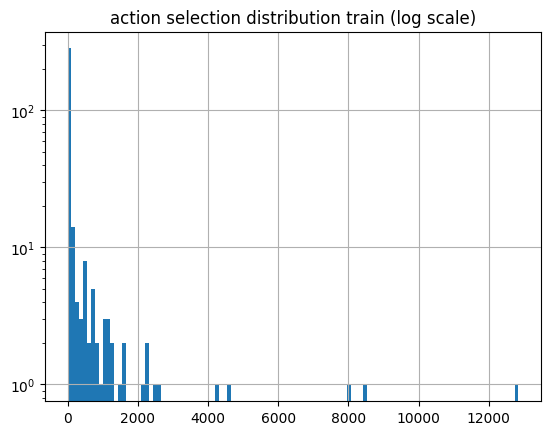

In [26]:
if CREATE_TRAJS:
    action_counts.hist(bins=action_counts.nunique(), log=True)
    plt.title('action selection distribution train (log scale)')
    print("# possible actions: {}".format(len(action_bin_definition)))
    print("actions never chosen: {}".format((action_counts == 0).sum()))
    most_chosen_action = action_bin_definition[discretized_actions.mode()[0]]
    print("most chosen action: (tv: {}, peep:{}, fio2: {}), chosen {} times".format(*most_chosen_action, discretized_actions.value_counts().max()))

# possible actions: 343
actions never chosen: 170
most chosen action: (tv: (7.5, 10), peep:(40, 45), fio2: (5, 7)), chosen 4487 times


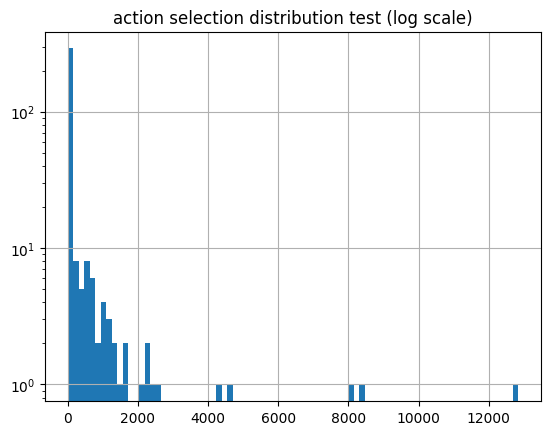

In [27]:
if CREATE_TRAJS:
    observed_action_counts_test = discretized_actions_test.value_counts()
    action_info_test = {}
    action_counts_test = []
    for action_id in range(len(action_bin_definition)):
        count = observed_action_counts_test[action_id] if action_id in observed_action_counts_test else 0
        action_info_test[action_id] = (action_bin_definition, count)
        action_counts_test.append(count)
    action_counts_test = pd.Series(action_counts_test)
    action_counts.hist(bins=action_counts_test.nunique(), log=True)
    plt.title('action selection distribution test (log scale)')
    print("# possible actions: {}".format(len(action_bin_definition)))
    print("actions never chosen: {}".format((action_counts_test == 0).sum()))
    most_chosen_action = action_bin_definition[discretized_actions_test.mode()[0]]
    print("most chosen action: (tv: {}, peep:{}, fio2: {}), chosen {} times".format(*most_chosen_action, discretized_actions_test.value_counts().max()))

In [28]:
if CREATE_TRAJS:
    # state-action pair
    state_actions = list(itertools.product(range(n_states), range(len(action_bin_definition)),))
    print("{} states x {} actions = {} state-action pairs".format(n_states, len(action_bin_definition), len(state_actions)))
    state_action_ids = list(map(lambda x: "{}-{}".format(x[0], x[1]), state_actions))

650 states x 343 actions = 222950 state-action pairs


In [29]:
if CREATE_TRAJS:
    train_set['terminal'] = False
    train_set.loc[train_set.groupby('icustay_id').tail(1).index, 'terminal'] = True

    train_set['state_action_id'] = train_set.agg('{0[state]}-{0[action_discrete]}'.format, axis=1)
    train_set['next_state'] = train_set.state.astype(str).shift(-1)
    # create special terminal states for both outcomes
    terminal_mort = train_set['state'].max() + 1
    terminal_nonmort = train_set['state'].max() + 2

    train_set.loc[train_set.terminal & (train_set.mort90day == 't'), 'next_state'] = terminal_mort
    train_set.loc[train_set.terminal & (train_set.mort90day == 'f'), 'next_state'] = terminal_nonmort

    # State-Action-NextState_ID
    train_set['sans_id'] = train_set.agg('{0[state_action_id]}-{0[next_state]}'.format, axis=1)
    observed_saction_counts = train_set['state_action_id'].value_counts()
    saction_info = {}
    saction_counts = []
    for i, saction_id in enumerate(state_action_ids):
        count = observed_saction_counts[saction_id] if saction_id in observed_saction_counts else 0
        state, action = saction_id.split('-')
        saction_info[saction_id] = (saction_id, i, count, int(state), int(action), action_bin_definition[int(action)], )
        saction_counts.append(count)
    saction_counts = pd.Series(saction_counts)
    # saction_info

C:\Users\hmilab\AppData\Local\Temp\ipykernel_15500\4036423696.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_set['terminal'] = False
C:\Users\hmilab\AppData\Local\Temp\ipykernel_15500\4036423696.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_set['state_action_id'] = train_set.agg('{0[state]}-{0[action_discrete]}'.format, axis=1)
C:\Users\hmilab\AppData\Local\Temp\ipykernel_15500\4036423696.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

In [30]:
if CREATE_TRAJS:
    test_set['state_action_id'] = test_set.agg('{0[state]}-{0[action_discrete]}'.format, axis=1)
    test_set['next_state'] = test_set.state.astype(str).shift(-1)
    # State-Action-NextState_ID
    test_set['sans_id'] = test_set.agg('{0[state_action_id]}-{0[next_state]}'.format, axis=1)
    observed_saction_counts_test = test_set['state_action_id'].value_counts()
    
    
    test_set.loc[train_set.terminal & (train_set.mort90day == 't'), 'next_state'] = terminal_mort
    test_set.loc[train_set.terminal & (train_set.mort90day == 'f'), 'next_state'] = terminal_nonmort
    
    saction_info_test = {}
    saction_counts_test = []
    for i, saction_id in enumerate(state_action_ids):
        count = observed_saction_counts_test[saction_id] if saction_id in observed_saction_counts_test else 0
        state, action = saction_id.split('-')
        saction_info_test[saction_id] = (saction_id, i, count, int(state), int(action), action_bin_definition[int(action)], )
        saction_counts_test.append(count)
    saction_counts_test = pd.Series(saction_counts_test)
    # saction_info_test

C:\Users\hmilab\AppData\Local\Temp\ipykernel_15500\247294981.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_set['state_action_id'] = test_set.agg('{0[state]}-{0[action_discrete]}'.format, axis=1)
C:\Users\hmilab\AppData\Local\Temp\ipykernel_15500\247294981.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_set['next_state'] = test_set.state.astype(str).shift(-1)
C:\Users\hmilab\AppData\Local\Temp\ipykernel_15500\247294981.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of cal

In [31]:
if CREATE_TRAJS:
    saction_info_df = pd.DataFrame([[*v,] for k, v in  saction_info.items()], columns=['saction_id', 'index', 'count', 'state', 'action', 'action'])
    saction_info_df_test = pd.DataFrame([[*v,] for k, v in  saction_info_test.items()], columns=['saction_id', 'index', 'count', 'state', 'action', 'action'])

# state-action pairs: 222950
# state-action pairs never visited: 207762
most visited state-action pair in train: (tv: (7.5, 10), peep:(40, 45), fio2: (5, 7), state: 9), visited 153 times


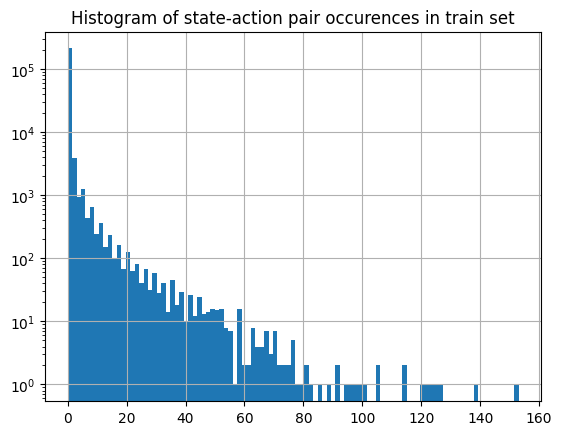

In [32]:
if CREATE_TRAJS:
    print("# state-action pairs: {}".format(len(state_action_ids)))
    print("# state-action pairs never visited: {}".format((saction_counts == 0).sum()))
    most_frequent_saction = saction_info_df[saction_info_df.index == saction_counts.argmax()].to_numpy()[0]
    most_chosen_action = action_bin_definition[discretized_actions.mode()[0]]
    saction_counts.hist(bins=saction_counts.nunique(), log=True)
    plt.title("Histogram of state-action pair occurences in train set")
    print("most visited state-action pair in train: (tv: {}, peep:{}, fio2: {}, state: {}), visited {} times".format(*most_chosen_action, most_frequent_saction[3], most_frequent_saction[2]))

most visited state-action pair in train: (tv: (7.5, 10), peep:(40, 45), fio2: (5, 7), state: 9), visited 153 times


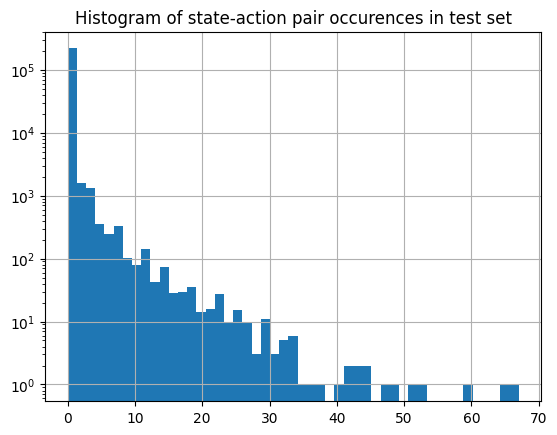

In [33]:
if CREATE_TRAJS:
    most_frequent_saction_test = saction_info_df[saction_info_df.index == saction_counts.argmax()].to_numpy()[0]
    most_chosen_action_test = action_bin_definition[discretized_actions.mode()[0]]
    saction_counts_test.hist(bins=saction_counts_test.nunique(), log=True)
    plt.title("Histogram of state-action pair occurences in test set")
    print("most visited state-action pair in train: (tv: {}, peep:{}, fio2: {}, state: {}), visited {} times".format(*most_chosen_action_test, most_frequent_saction_test[3], most_frequent_saction_test[2]))

In [34]:
if not CREATE_TRAJS:
    test_set = pd.read_csv('data/test_{}_traj_{}.csv'.format(shaping_name, seed))
    train_set = pd.read_csv('data/train_{}_traj_{}.csv'.format(shaping_name, seed))

## Trajectory construction

C:\Users\hmilab\AppData\Local\Temp\ipykernel_15500\3047370848.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_set['traj_count'] = train_set.sort_values(['icustay_id', 'start_time']).groupby('icustay_id').cumcount()
C:\Users\hmilab\AppData\Local\Temp\ipykernel_15500\3047370848.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_set['traj_count_inv'] = train_set.sort_values(['icustay_id', 'start_time']).groupby('icustay_id').cumcount(ascending=False)
C:\Users\hmilab\AppData\Local\Temp\ipykernel_15500\3047370848.py:

count    5272.000000
mean       15.827580
std         3.371015
min         7.000000
25%        13.750000
50%        18.000000
75%        18.000000
max        18.000000
Name: traj_count, dtype: float64

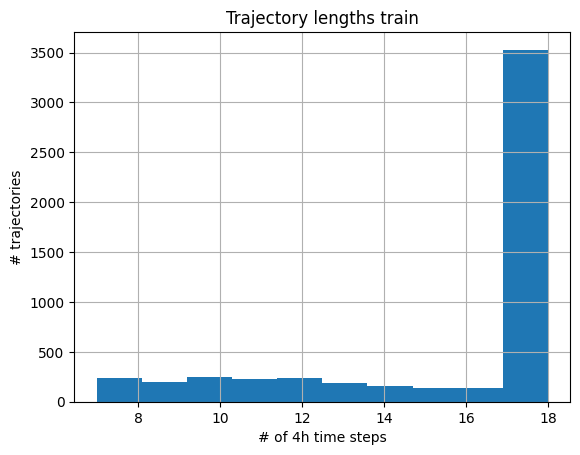

In [35]:
train_set['traj_count'] = train_set.sort_values(['icustay_id', 'start_time']).groupby('icustay_id').cumcount()
train_set['traj_count_inv'] = train_set.sort_values(['icustay_id', 'start_time']).groupby('icustay_id').cumcount(ascending=False)
train_set['traj_len'] = train_set.groupby('icustay_id')['traj_count'].transform('max')
train_set['traj_len'] += 1

trajectory_lengths = train_set.groupby('icustay_id').traj_count.max() + 1
trajectory_lengths.hist()
plt.title('Trajectory lengths train')
plt.xlabel('# of 4h time steps')
plt.ylabel('# trajectories')
trajectory_lengths.describe()

C:\Users\hmilab\AppData\Local\Temp\ipykernel_15500\2594484659.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_set['traj_count'] = test_set.sort_values(['icustay_id', 'start_time']).groupby('icustay_id').cumcount()
C:\Users\hmilab\AppData\Local\Temp\ipykernel_15500\2594484659.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_set['traj_count_inv'] = test_set.sort_values(['icustay_id', 'start_time']).groupby('icustay_id').cumcount(ascending=False)
C:\Users\hmilab\AppData\Local\Temp\ipykernel_15500\2594484659.py:3: P

count    1754.000000
mean       15.907070
std         3.331799
min         7.000000
25%        14.000000
50%        18.000000
75%        18.000000
max        18.000000
Name: traj_count, dtype: float64

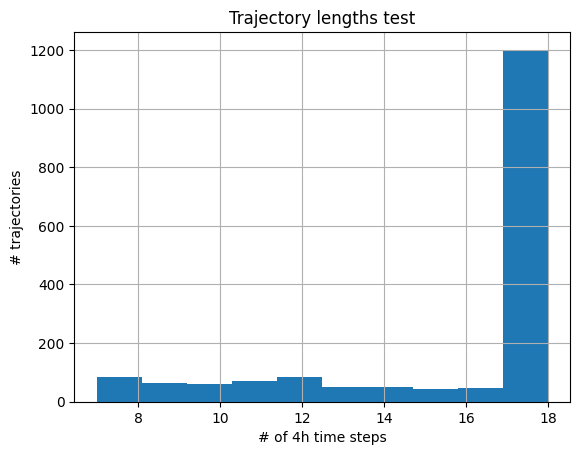

In [36]:
test_set['traj_count'] = test_set.sort_values(['icustay_id', 'start_time']).groupby('icustay_id').cumcount()
test_set['traj_count_inv'] = test_set.sort_values(['icustay_id', 'start_time']).groupby('icustay_id').cumcount(ascending=False)
test_set['traj_len'] = test_set.groupby('icustay_id')['traj_count'].transform('max')
test_set['traj_len'] += 1

trajectory_lengths_test = test_set.groupby('icustay_id').traj_count.max() + 1
trajectory_lengths_test.hist()
plt.title('Trajectory lengths test')
plt.xlabel('# of 4h time steps')
plt.ylabel('# trajectories')
trajectory_lengths_test.describe()

In [37]:
terminals = train_set.groupby('icustay_id').max('traj_count').reset_index().set_index('Unnamed: 0')['traj_count']
terminals = (~terminals.isna()).rename('terminal')
if 'terminal' in train_set.columns:
    # need to remove this column if it already exists
    del(train_set['terminal'])
train_set = train_set.join(terminals, on='Unnamed: 0', how='left')
train_set['terminal'] = train_set.terminal.fillna(False)
train_set['nterminal'] = train_set.terminal.shift(-1).fillna(False)

terminals = test_set.groupby('icustay_id').max('traj_count').reset_index().set_index('Unnamed: 0')['traj_count']
terminals = (~terminals.isna()).rename('terminal')
if 'terminal' in test_set.columns:
    # need to remove this column if it already exists
    del(test_set['terminal'])
test_set = test_set.join(terminals, on='Unnamed: 0', how='left')
test_set['terminal'] = test_set.terminal.fillna(False)
test_set['nterminal'] = test_set.terminal.shift(-1).fillna(False)

C:\Users\hmilab\AppData\Local\Temp\ipykernel_15500\4086799166.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_set['terminal'] = train_set.terminal.fillna(False)
C:\Users\hmilab\AppData\Local\Temp\ipykernel_15500\4086799166.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_set['nterminal'] = train_set.terminal.shift(-1).fillna(False)
C:\Users\hmilab\AppData\Local\Temp\ipykernel_15500\4086799166.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.i

In [38]:
assert train_set.groupby('icustay_id').terminal.sum().max() == 1, "Every icustay should have exactly 1 terminal state"
assert test_set.groupby('icustay_id').terminal.sum().max() == 1, "Every icustay should have exactly 1 terminal state"
assert train_set.groupby('icustay_id').terminal.sum().min() == 1, "Every icustay should have exactly 1 terminal state"
assert test_set.groupby('icustay_id').terminal.sum().min() == 1, "Every icustay should have exactly 1 terminal state"

In [39]:
# generate s,s',a tuples for transition matrix approximation
  
# calculate joint state-action probabilities
pr_state_action = pd.DataFrame((train_set.state_action_id.value_counts() / train_set.shape[0])).reset_index().rename(columns={'state_action_id': 'sa_id', 'count': 'pr_sa'})


# calculate joint s-s'-a probabilities
sans_id = '' # state-action-nstate id
pr_nstate_state_action = pd.DataFrame(train_set.sans_id.value_counts() / train_set.shape[0]).reset_index().rename(columns={'index': 'sans_id', 'count': 'pr_sans'})
pr_nstate_state_action['sa_id'] = list(map(lambda x: '-'.join(x[:2]), pr_nstate_state_action.sans_id.str.split('-')))
pr_sans = pr_nstate_state_action.merge(pr_state_action, on='sa_id', how='inner').set_index('sans_id')

# calculate transition probabilities
pr_trans = pr_sans.pr_sans / pr_sans.pr_sa
pr_trans = pd.DataFrame(pr_trans).rename(columns={0: 'pr_t'})



Text(0.5, 1.0, 'Distribution of nonzero transition probabilities')

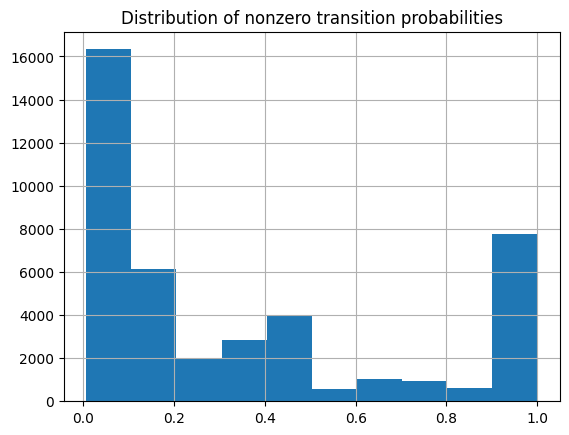

In [40]:
pr_trans.pr_t.hist()
pr_trans
plt.title('Distribution of nonzero transition probabilities')

In [41]:
split_sans = pd.DataFrame(pr_trans.index.str.split('-').tolist()).rename(columns={0:'state', 1: 'action', 2: 'nstate'})
split_sans.state = split_sans.state.astype(int)
split_sans.action = split_sans.action.astype(int)
split_sans.nstate = split_sans.nstate.astype(int)
assert split_sans.action.max() <= (7**3 - 1), "the highest action id exceeds the number of actions" # number of discrete actions
pr_trans = pr_trans.reset_index().merge(split_sans, left_index=True, right_index=True)

In [42]:
# all transition probabilities for a state-action pair should sum to 1, there could be some rounding errors
print("{:.5f}% of state-action's probs does not sum to 1, max diff to 1 is {}".format(
    (~(pr_trans.groupby(['state', 'action']).pr_t.sum() >= 1.0)).to_numpy().mean(),
    np.diff(pr_trans.groupby(['state', 'action']).pr_t.sum(), 1).max(),
))
assert np.diff(pr_trans.groupby(['state', 'action']).pr_t.sum(), 1).max() < 1e-15, "transition probabilities for a state-action pair should sum (approx.) to 1"

0.05030% of state-action's probs does not sum to 1, max diff to 1 is 3.3306690738754696e-16


In [43]:
np.diff(pr_trans.groupby(['state', 'action']).pr_t.sum(), 1).max()

3.3306690738754696e-16

Text(0.5, 1.0, 'Histogram of nonzero transition probabilities')

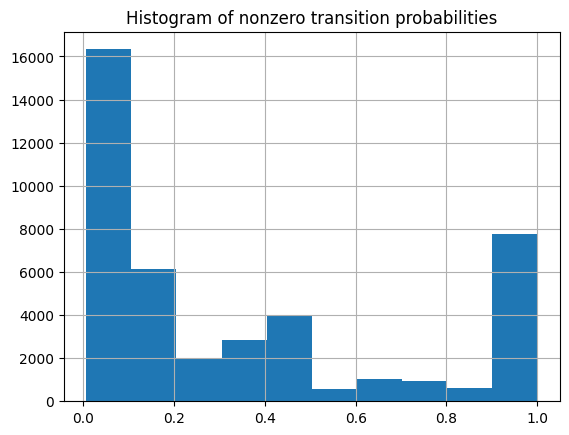

In [44]:
pr_trans.pr_t.hist()
plt.title('Histogram of nonzero transition probabilities')

## Immediate reward definition

In [45]:
def compliance_to_potential(compliance):
    return compliance * COMPLIANCE_SCALAR

def potential_diff(x):
    if np.isnan(x.iloc[1]):
        p1 = 0.0 # see Grzes, AAMAS 2017
    else:
        p1 = GAMMA * x.iloc[1]
    return p1 - x.iloc[0]

train_set['reward'] = 0
test_set['reward'] = 0
train_set.loc[train_set.terminal & (train_set.mort90day == 't'), 'reward'] = -100
test_set.loc[test_set.terminal & (test_set.mort90day == 't'), 'reward'] = -100
train_set.loc[train_set.terminal & (train_set.mort90day == 'f'), 'reward'] = 100
test_set.loc[test_set.terminal & (test_set.mort90day == 'f'), 'reward'] = 100


assert train_set.reward.isna().sum() == 0, "All immediate rewards should be set"
assert test_set.reward.isna().sum() == 0, "All immediate rewards should be set"
assert train_set[train_set.terminal].reward.isin({-100, 100}).all(), "Transitions to terminal states should have value -100 or 100"
assert test_set[test_set.terminal].reward.isin({-100, 100}).all(), "Transitions to terminal states should have value -100 or 100"

if SHAPING:
    # TODO FdH: implement shaping
    if SHAPING == 'avgpotential2':
        train_set['compliance'] = safety.state_compliance_clinical(train_set, safety.avg_clinical_timestep)
    elif SHAPING == 'allpotential':
        train_set['compliance'] = safety.state_compliance_clinical(train_set, safety.all_clinical_timestep)
    else:
        raise ValueError('Unknown shaping approach')
    train_set['potential'] = compliance_to_potential(train_set['compliance'])
    if 'potential' in SHAPING:
        train_set['shaping_reward_unshift'] = train_set.groupby('icustay_id').rolling(window=2)['potential'].apply(potential_diff).fillna(0.0).reset_index().set_index('level_1')['potential']
        train_set['shaping_reward'] = train_set['shaping_reward_unshift'].shift(-1)
        train_set.loc[train_set.terminal, 'shaping_reward'] = train_set['potential']
    elif 'base' in SHAPING:
        train_set['shaping_reward'] = train_set['potential']
    
    train_set['reward'] = train_set.reward + train_set.shaping_reward

reward
 0.0      38062
 100.0     2576
-100.0     1578
Name: count, dtype: int64

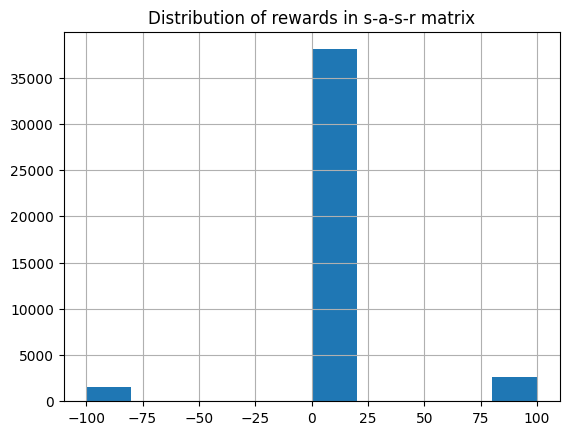

In [46]:
# 1. compute average immediate reward for each s-s'-a with support from the data.
# 2. where -100 if terminal and 90 day mortality, +100 if terminal and 90 day mortality, 0 otherwise
# 3. element-wise multiply with transition matrix pr_trans
# 4. sum over s' dimension to obtain R(s, a) < sum because transition matrix has probabilities

# step 1: compute average immediate reward for each s-s'-a with support from the data.
r_sans = train_set.groupby('sans_id')['reward'].mean()
r_sans.hist()
plt.title('Distribution of rewards in s-a-s-r matrix')
split_r_sans = pd.DataFrame(r_sans.index.str.split('-').tolist()).rename(columns={0:'state', 1: 'action', 2: 'nstate'})
split_r_sans.state = split_r_sans.state.astype(int)
split_r_sans.action = split_r_sans.action.astype(int)
split_r_sans.nstate = split_r_sans.nstate
r_sans = r_sans.reset_index().merge(split_r_sans, left_index=True, right_index=True)
r_sans.reward.value_counts()

In [47]:
pr_r_sans = r_sans.merge(pr_trans, on='sans_id')
assert pr_r_sans.pr_t.isna().sum() == 0, "transition probabilities should never be na"
assert pr_r_sans.reward.isna().sum() == 0, "rewards should never be na"
assert pr_r_sans.shape[0] == r_sans.shape[0], "all reward rows should be in transition-reward dataframe"
assert pr_r_sans.shape[0] == pr_sans.shape[0], "all transition rows should be in transition-reward dataframe"
assert pr_r_sans.sans_id.value_counts().max() == 1, "a s-a-r-s tuple should occur exactly once"
assert pr_r_sans.sans_id.value_counts().min() == 1, "a s-a-r-s tuple should occur exactly once"

In [48]:
# step 3: element-wise multiply with transition matrix pr_trans
pr_r_sans['weighted_reward'] = pr_r_sans.reward * pr_r_sans.pr_t
immediate_reward = pr_r_sans.groupby(['state_x', 'action_x']).weighted_reward.sum()
immediate_reward = immediate_reward.reset_index().rename(columns={'state_x': 'state', 'action_x': 'action', 'weighted_reward': 'immediate_reward'})

immediate_reward
 0.000000      11704
 100.000000      382
 50.000000       250
 33.333333       202
-100.000000      191
               ...  
 5.084746          1
-1.923077          1
-1.428571          1
 7.462687          1
-4.545455          1
Name: count, Length: 278, dtype: int64

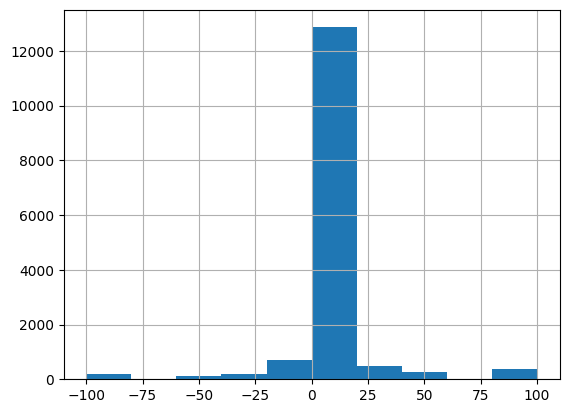

In [49]:
immediate_reward.immediate_reward.hist()
immediate_reward.immediate_reward.value_counts()

In [50]:
immediate_reward['state_action_id'] = immediate_reward.agg('{0[state]:.0f}-{0[action]:.0f}'.format, axis=1)

In [51]:
pr_trans[(pr_trans.state==0) & (pr_trans.action == 71)]

,sans_id,pr_t,state,action,nstate


In [52]:
pr_sans[pr_sans.sa_id=='0-71']['pr_sa']

Series([], Name: pr_sa, dtype: float64)

In [53]:
0.000332 * train_set.shape[0]

27.703076

In [54]:
pr_nstate_state_action.sans_id

0            9-169-9
1        264-169-264
2          61-169-61
3        123-169-123
4        222-169-222
            ...     
42211    500-183-323
42212    500-190-500
42213    189-190-500
42214     45-190-189
42215    279-141-549
Name: sans_id, Length: 42216, dtype: object

In [55]:
pr_nstate_state_action

,sans_id,pr_sans,sa_id
0,9-169-9,0.001007,9-169
1,264-169-264,0.000803,264-169
2,61-169-61,0.000803,61-169
3,123-169-123,0.000791,123-169
4,222-169-222,0.000791,222-169
...,...,...,...
42211,500-183-323,0.000012,500-183
42212,500-190-500,0.000012,500-190
42213,189-190-500,0.000012,189-190
42214,45-190-189,0.000012,45-190


In [56]:
pr_nstate_state_action

,sans_id,pr_sans,sa_id
0,9-169-9,0.001007,9-169
1,264-169-264,0.000803,264-169
2,61-169-61,0.000803,61-169
3,123-169-123,0.000791,123-169
4,222-169-222,0.000791,222-169
...,...,...,...
42211,500-183-323,0.000012,500-183
42212,500-190-500,0.000012,500-190
42213,189-190-500,0.000012,189-190
42214,45-190-189,0.000012,45-190


In [57]:
(train_set.icustay_id == 299994).any()

False

In [58]:
if shaping_name == 'unshaped':
    test_set.to_csv('../mimic-data/test_{}_traj_{}.csv'.format(shaping_name, seed))
    train_set.to_csv('../mimic-data/train_{}_traj_{}.csv'.format(shaping_name, seed))

In [59]:
safety.action_compliance_clinical(train_set).mean()

0.5519815922246324

In [60]:
safety.state_compliance_clinical(train_set, safety.avg_clinical_timestep).mean()

0.9719658928849634

# Training a policy

In [61]:
immediate_reward[['state', 'action', 'immediate_reward']]
# matrix of immediate rewards
sar = np.full((n_states, 7**3), np.nan)
for state, action, reward in immediate_reward[['state', 'action', 'immediate_reward']].to_numpy():
    sar[int(state), int(action)] = reward

# Qn = {} # maps n to q tables

In [62]:
# According to the tabular FQI algorithm in Ernst, Geurts & Wehenkel (2005), Figure 1
# and Peine's supplementary discussion "A: Evaluation of Policies".
def peine_mc_iterate(snsasr, r, Qn, gamma, n_epochs=1, learning_rate=0.1, unsafety_prob=0.0, safety_map=safety.action_id_compliance):
    """
    Monte-carlo-based iteration of the training procedure according to tabular FQI & Peine's supplementary discussion.
    
    snsas: numpy ndarray with discretized state-nextstate-action tuples
    r: a function that returns the immediate reward for a state-action pair
    Qn: dictionary that maps iteration indices to Qn-estimates
    n: iteration number
    gamma: discount factor
    n_epochs: number of times to iterate over dataset
    learning rate: learning rate alpha
    """
    def epoch(snsasr, r, Qn, gamma, learning_rate, unsafety_prob, safety_map):
        for i, (s, ns, a, er) in enumerate(snsasr):
            if unsafety_prob == 1.0:
                # We do not care about the safety rules
                Qn[s,a] = Qn[s,a] + learning_rate * (er + gamma * np.max(Qn[int(ns),:]) - Qn[s,a])
            elif unsafety_prob == 0.0:
                if safety_map[a]:
                    Qn[s,a] = Qn[s,a] + learning_rate * (er + gamma * np.max(Qn[int(ns), safety_map]) - Qn[s,a])
                else:
                    # taken action not safe, disregard sample
                    pass
            else:
                raise ValueError("Only unsafety probs in {0.0, 1.0} supported for now")
                #TODO FdH: implement unsafety probs (0.0, 0.0}
        return Qn
    assert Qn.shape == (n_states+2, 7**3)
    assert safety_map is not None or unsafety_prob == 0.0
    for n in range(n_epochs):
        Qn = epoch(snsasr, r, Qn, gamma, learning_rate, unsafety_prob, safety_map)
        assert np.nanmax(Qn) < 100, "Scores > 100 should not occur, found: {}".format(np.nanargmax(Qn))
        print('.', end='')
    return Qn


def ernst_iterate(snsasr, Qn, n, gamma, regressor, action_space, state_repr=None, action_repr=utils.to_discrete_action_bins):
    """
    snsas: numpy ndarray with discretized state_id-nextstate_id-action_id tuples
    r: immediate rewards
    Qn: dictionary that maps iteration indices to Qn estimates/estimators
    n: iteration number
    gamma: discount factor
    regression: sklearn regression class
    action_space: iterator that retuns all actions in
    action_repr: function that returns the action representation
    """
    def batches(X, batch_size):
        n_batches = int(math.ceil(X.shape[0] / batch_size))
        batches = []
        for i in range(n_batches):
            batch_start = i * batch_size
            batch_end = min(batch_start + batch_size, X.shape[0])
            batches.append((batch_start, batch_end))
        return batches

    def prediction_set(X, action_space):
        shape_x = X.shape
        n_actions = action_space.shape[0]
        action_dims = action_space.shape[1]
        repeated_X = X.repeat(n_actions, axis=0).reshape((shape_x[0] * n_actions, shape_x[1]))
        repeated_action_reprs = np.tile(action_space, (shape_x[0], 1)).reshape(repeated_X.shape[0], action_dims)
        return np.concatenate([repeated_X, repeated_action_reprs], axis=1)

    Q_hat = Qn[n]
    n = n + 1
    # terminal states only
    snsasr_t = snsasr[snsasr[:,1] >= 650] # 650 = number of non-terminal states
    r_t = snsasr_t[:, 3]
    # non-terminal states only
    snsasr = snsasr[snsasr[:,1] < 650] # 650 = number of non-terminal states
    a_reprs = np.array(list(map(action_repr, snsasr[:,2])))
    action_space_reprs = np.array(list(map(action_repr, action_space)))
    s_reprs = state_repr.transform(snsasr[:, 0].reshape(-1, 1))
    ns_reprs = state_repr.transform(snsasr[:, 1].reshape(-1, 1))
    r = snsasr[:, 3]
    X_train = hstack((s_reprs, a_reprs))
    # generate prediction dataset of length X.shape[0] * len(action_space)
    batch_size = int(X_train.shape[0] / 100)
    y_train = np.array([])
    for batch_start, batch_end in batches(X_train, batch_size):
        X_batch = ns_reprs[batch_start:batch_end, :].toarray()
        X_preds = prediction_set(X_batch, action_space_reprs)
        # predict Q scores for prediction dataset
        y_preds = Q_hat.predict(X_preds)
        # create targets with immediate reward and highest Q score for each row
        y_preds = y_preds.reshape(X_batch.shape[0], len(action_space_reprs))
        y_train = np.concatenate([y_train, r[batch_start:batch_end] + gamma * y_preds.max(axis=1)], axis=0)
        print('.', end ='')
    # terminal states
    a_reprs_t = np.array(list(map(action_repr, snsasr_t[:,2])))
    s_reprs_t = state_repr.transform(snsasr_t[:, 0].reshape(-1, 1))
    X_train_t = hstack((s_reprs_t, a_reprs_t))
    y_train_t = r_t
    print("y_train_t {}".format(y_train_t.shape))
    X_train_n = vstack((X_train_t, X_train))
    print("y_train {}".format(y_train.shape))
    y_train = np.concatenate((y_train, y_train_t))
    print("y_train {}".format(y_train.shape))
    print("X_train_n {}".format(X_train_n.shape))
    Q_hat_new = regressor()
    Q_hat_new.fit(X_train_n, y_train)
    return n, Q_hat_new


# TODO
# implement a regressor that wraps an OLS regressor in the following way:
#  1. creates an OLS regressor for each state
#  2. implements a predict() function that first looks up the right state OLS
#     and then calls predict() on the regressor there with the action levels as input
#  3. implements a fit() function that first segments X into buckets with the same state-action pair
#     then creates a regressor for that pair
#     and calls fit() on that pair << TODO: BUT GIVEN WHAT INPUT? does this only work for a three-dimensional action input?
class PerStateActionOLS():
    def __init__(self, states, default=None):
        self.regressors = {
            state: LinearRegression() for state in states
        }
        self.default = default
        
    def fit(self, X, y, states):
        """
        Fits a set of 
        """
        assert len(X) == len(states) == len(y), "Number of train samples, labels and states should be equal"
        X = np.array(X)
        X_df = pd.DataFrame(X, columns=['X_{}'.format(i) for i in range(X.shape[1])])
        X_cols = list(X_df.columns)
        X_df.loc[:, 'state'] = states
        X_df.loc[:, 'y'] = y
        groups = X_df.groupby('state')
        for k in groups.groups.keys():
            X_group = groups.get_group(k)[X_cols].to_numpy()
            y_group = groups.get_group(k)['y'].to_numpy()
            self.regressors[k].fit(X_group, y_group)
    
    def predict(self, X, states):
        def predict_single(row, X_cols):
            if row.state in self.regressors.keys():
                return self.regressors[row.state].predict(row[X_cols].to_numpy().reshape(1,-1))
            else:
                if self.default is None:
                    raise ValueError('Cannot predict for state {} without default prediction.'.format(row.state))
                else:
                    return self.default
            
        if isinstance(X, Iterable):
            assert len(X) == len(states), "Number of train samples, labels and states should be equal"
        X = np.array(X)
        X_df = pd.DataFrame(X, columns=['X_{}'.format(i) for i in range(X.shape[1])])
        X_cols = list(X_df.columns)
        X_df.loc[:, 'state'] = states
        predictions = X_df.apply(lambda x: predict_single(x, X_cols), axis=1)
        return predictions

class OneHotStateActionOLS():
    def __init__(self, obs_states, all_states=range(650), *args, **kwargs):
        # TODO: ensure that all states are passed
        if type(obs_states) == set:
            obs_states = list(obs_states)
        obs_states = np.array(obs_states).reshape(-1, 1)
        self.state_encoder = OneHotEncoder(categories=[all_states,]).fit(obs_states)
        self.regressor = LinearRegression()
    
    def encode(self, X, states):
        state_encoding = self.state_encoder.transform(states)
        return np.concatenate((X, state_encoding.todense()), axis=1)

    def fit(self, X, y):
        self.regressor.fit(X, y)
    
    def predict(self, X):
        X = np.array(X)
        states = np.array(states).reshape(-1, 1)
        X_new = self.encode(X, states)
        return self.regressor.predict(X_new)


class DummyRegressor:
    def __init__(self, return_val=0):
        self.return_val = return_val
        
    def predict(self, X, *args, **kwargs):
        return np.repeat([self.return_val], X.shape[0]).reshape(-1, 1)

In [63]:
q_file = 'models/peine_mc_{}_{}_q_table_{}.bin'.format(shaping_name, UNSAFETY_PROB, seed)
if os.path.isfile(q_file):
    q_dumped = joblib.load(q_file)
    q_mcp_nan = q_dumped['model']
    q_mcp_loaded = True
else:
    q_mcp_loaded = False

In [64]:
0.01 * 10000

100.0

2024/04/08 run time: 71 mins

In [65]:
force_training = True
if not q_mcp_loaded or force_training:
    q_init_val = 0
    q_init = np.full((n_states + 2, 7**3), float(q_init_val))
    #  peine_mc_iterate(snsas, r, Qn, gamma, n_epochs=1, learning_rate=0.1):
    q_mcp = peine_mc_iterate(
        # TODO: why are the NaNs here? how to deal with these?
        snsasr=train_set[['state', 'next_state', 'action_discrete', 'reward']].astype(int).to_numpy(),
        r=sar,
        Qn=q_init,
        gamma=GAMMA,
        n_epochs=10000,
        learning_rate=0.01,
        unsafety_prob=UNSAFETY_PROB,
        safety_map=safety.action_id_compliance
    )


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

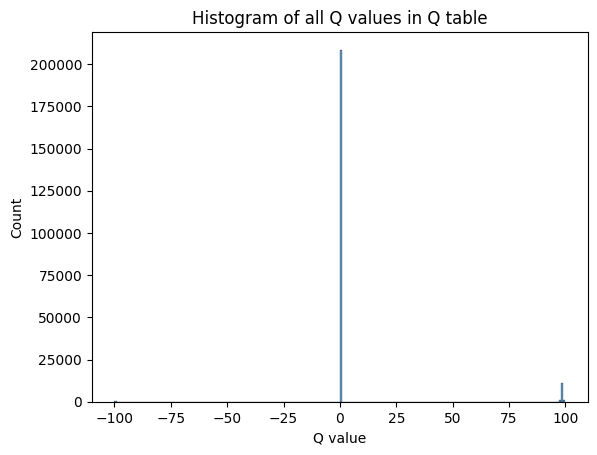

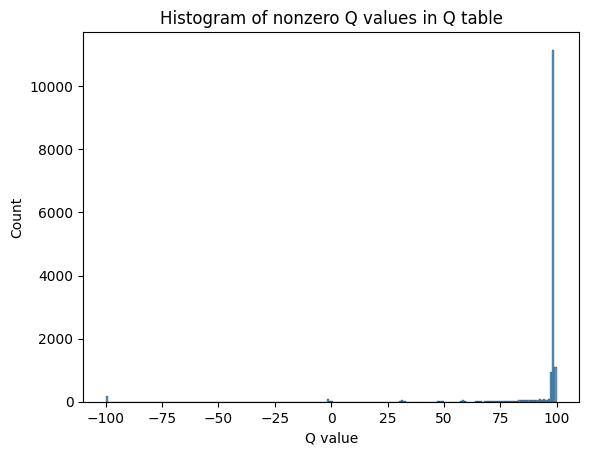

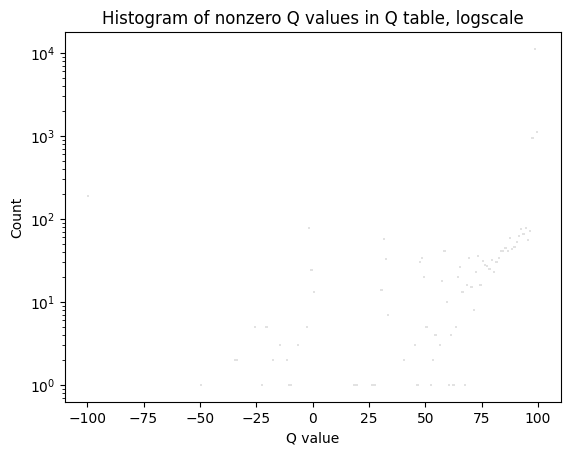

In [66]:
if not q_mcp_loaded or force_training:
    q_mcp_nan = q_mcp.copy()[:n_states, :]
    q_mcp_nan[q_mcp_nan == 0.0] = np.nan
else:
    q_mcp = np.nan_to_num(q_mcp_nan, 0.0)
sns.histplot(q_mcp.ravel(), bins=200)
plt.xlabel('Q value')
plt.title('Histogram of all Q values in Q table')
plt.show()
sns.histplot(q_mcp_nan.ravel(), bins=200)
plt.xlabel('Q value')
plt.title('Histogram of nonzero Q values in Q table')
plt.show()
sns.histplot(q_mcp_nan.ravel(), log_scale=(False, True), bins=200)
plt.xlabel('Q value')
plt.title('Histogram of nonzero Q values in Q table, logscale')
plt.show()

In [67]:
if not q_mcp_loaded:
    joblib.dump(
        {'hyperparameters': {
            'Q_init': q_init,
            'gamma': GAMMA,
            'n_epochs': 10000,
            'learning_rate': 0.01,
            'shaping': SHAPING,
            'shaping_scalar': COMPLIANCE_SCALAR,
            'unsafety_prob':UNSAFETY_PROB,
            'safety_map':safety.action_id_compliance            
        },
        'model': q_mcp_nan,
        },
        'models/peine_mc_{}_{}_q_table_{}.bin'.format(shaping_name, UNSAFETY_PROB, seed),
        compress=True
    )

In [68]:
# derive policy by taking argmax over non-nan q values
# policy_mcp = np.full()
q_mcp_nan[np.isnan(q_mcp_nan).all(axis=1),:] = 0

best_action_indices = np.nanargmax(q_mcp_nan, axis=1)

action_index_grid = np.tile(np.array(range(7**3)), 650).reshape((650, 7**3))
best_action_grid = np.repeat(best_action_indices, 7**3).reshape((650, 7**3))
best_action_bool = best_action_grid == action_index_grid
assert best_action_bool.shape == (n_states, 7**3)
assert (best_action_bool.sum(axis=1) == 1).all()
mcp_greedy = best_action_bool.astype(float)
assert (mcp_greedy.sum(axis=1) == 1).all()

In [69]:
# derive policy by taking softmax
q_mcp_neg = q_mcp.copy()[:n_states, :]
q_mcp_neg[q_mcp_neg == 0.0] = float('-inf')
mcp_softmax = scipy.special.softmax(q_mcp_neg, axis=1)
assert mcp_softmax.shape == (n_states, 7**3)
assert (mcp_greedy.sum(axis=1) == 1).all()

Global highest Q value 99.99999999999929 for tv, fio2, peep ranges: ((15, inf), (50, 55), (5, 7))
Highest avg Q value across states 99.99999999999929 for tv, fio2, peep ranges: ((2.5, 5), (30, 35), (0, 5))
Highest median Q value across states 56 for tv, fio2, peep ranges: ((2.5, 5), (30, 35), (0, 5))


C:\Users\hmilab\AppData\Local\Temp\ipykernel_15500\1235694641.py:3: RuntimeWarning: Mean of empty slice
  best_mean_a, best_mean_a_q = np.nanargmax(np.nanmean(q_mcp_nan, axis=0)), np.nanmax(np.nanmean(q_mcp_nan, axis=0))
c:\Users\hmilab\Anaconda3\envs\VM_RL\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


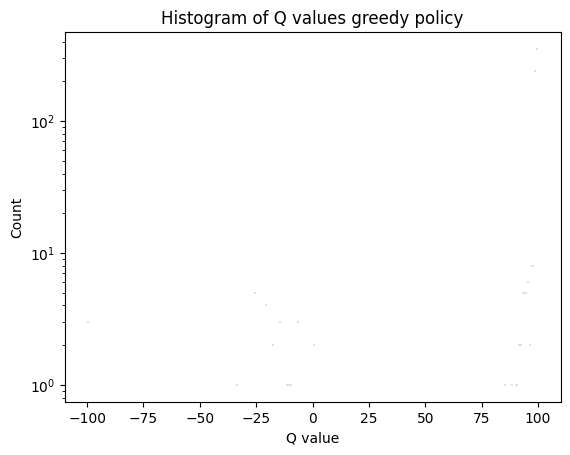

In [70]:
best_s, best_a = np.unravel_index(np.nanargmax(q_mcp_nan), (n_states, 7**3))
print("Global highest Q value {} for tv, fio2, peep ranges: {}".format(q_mcp_nan[best_s, best_a], utils.to_action_ranges(best_a)))
best_mean_a, best_mean_a_q = np.nanargmax(np.nanmean(q_mcp_nan, axis=0)), np.nanmax(np.nanmean(q_mcp_nan, axis=0))
print("Highest avg Q value across states {} for tv, fio2, peep ranges: {}".format(best_mean_a_q, utils.to_action_ranges(best_mean_a)))
best_med_a, best_med_a_q = np.nanargmax(np.nanmedian(q_mcp_nan, axis=0)), np.nanmax(np.nanmedian(q_mcp_nan, axis=0))
print("Highest median Q value across states {} for tv, fio2, peep ranges: {}".format(best_med_a, utils.to_action_ranges(best_med_a)))
sns.histplot(q_mcp_nan[mcp_greedy == 1.0].ravel(), log_scale=(False, True), bins=200)
plt.xlabel('Q value')
plt.title('Histogram of Q values greedy policy')
plt.show()

In [71]:
train_set['positive_outcome'] = train_set['mort90day'] == 'f'
estimated_mort_state_visit = train_set.groupby('state').mean('positive_outcome')[['positive_outcome']].to_numpy()

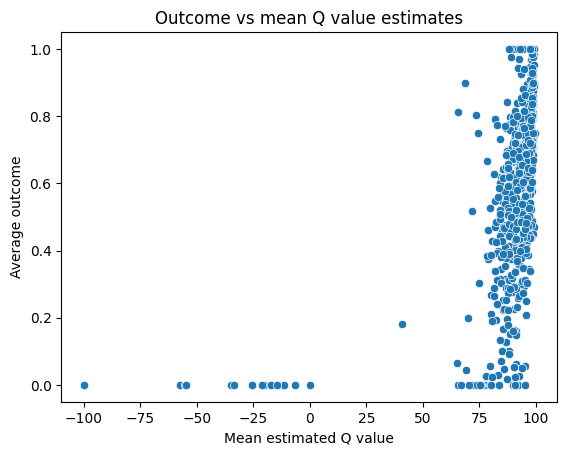

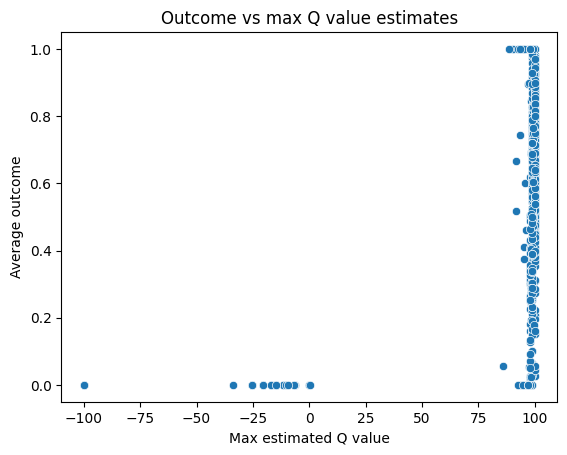

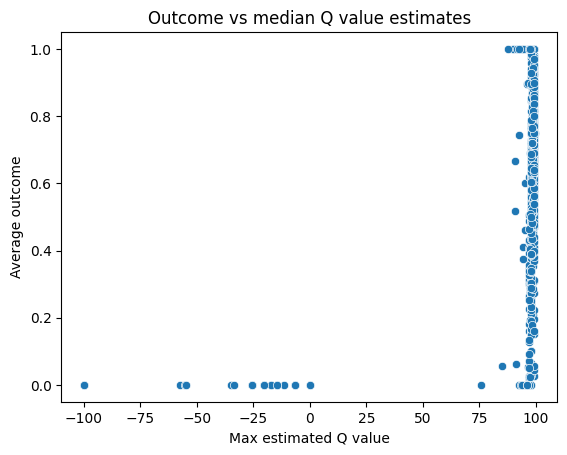

In [72]:
sns.scatterplot(x=np.nanmean(q_mcp_nan, axis=1), y=estimated_mort_state_visit.reshape(n_states,))
plt.xlabel('Mean estimated Q value')
plt.ylabel('Average outcome')
plt.title('Outcome vs mean Q value estimates')
plt.show()
sns.scatterplot(x=np.nanmax(q_mcp_nan, axis=1), y=estimated_mort_state_visit.reshape(n_states,))
plt.xlabel('Max estimated Q value')
plt.ylabel('Average outcome')
plt.title('Outcome vs max Q value estimates')
plt.show()
sns.scatterplot(x=np.nanmedian(q_mcp_nan, axis=1), y=estimated_mort_state_visit.reshape(n_states,))
plt.xlabel('Max estimated Q value')
plt.ylabel('Average outcome')
plt.title('Outcome vs median Q value estimates')
plt.show()

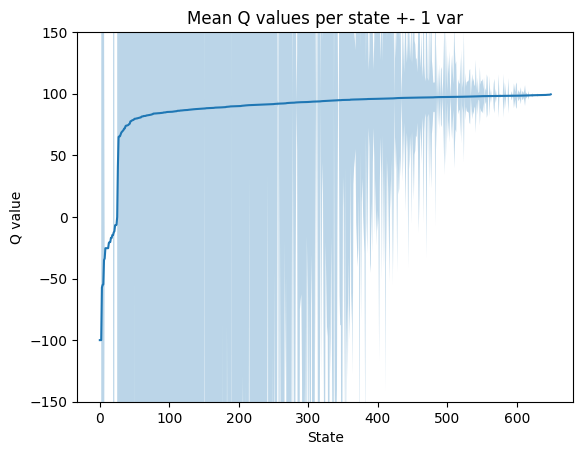

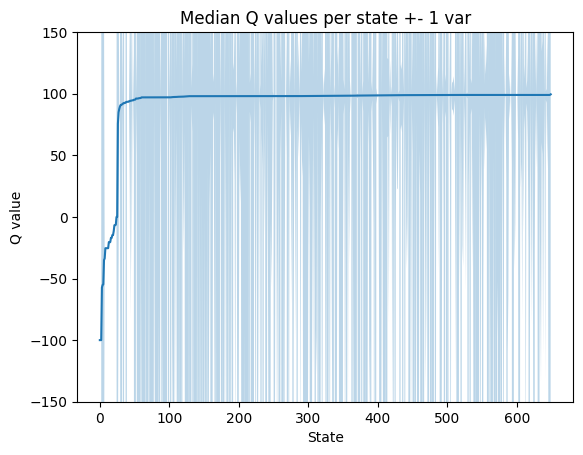

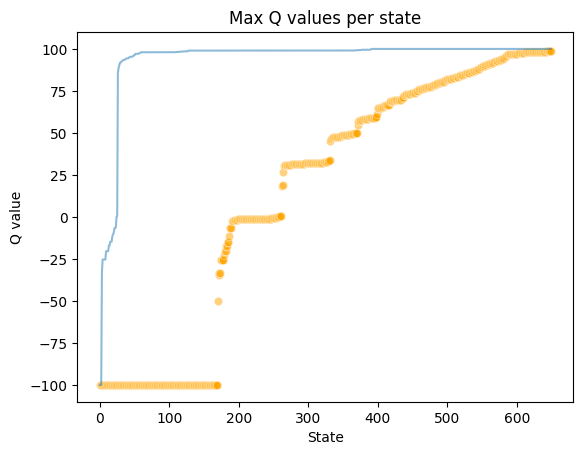

In [73]:
q_vars = np.nanvar(q_mcp_nan, axis=1)
q_means = np.nanmean(q_mcp_nan, axis=1)
q_medians = np.nanmedian(q_mcp_nan, axis=1)
q_maxs = np.nanmax(q_mcp_nan, axis=1)
q_mins = np.nanmin(q_mcp_nan, axis=1)
stacked = np.column_stack((q_means, q_medians, q_maxs, q_mins, q_vars))
xs = range(n_states)
means_sorted = np.array(sorted(stacked, key=lambda x: x[0]))
means_upper = means_sorted[:, 0] + means_sorted[:, -1]
means_lower = means_sorted[:, 0] - means_sorted[:, -1]
axs = sns.lineplot(x=xs, y=means_sorted[:, 0])
axs.fill_between(x=xs, y1=means_lower, y2=means_upper, alpha=.3)
axs.set_ylim(-150, 150)
plt.xlabel('State')
plt.ylabel('Q value')
plt.title('Mean Q values per state +- 1 var')
plt.show()

medians_sorted = np.array(sorted(stacked, key=lambda x: x[1]))
means_upper = medians_sorted[:, 0] + medians_sorted[:, -1]
means_lower = medians_sorted[:, 0] - medians_sorted[:, -1]
axs = sns.lineplot(x=xs, y=medians_sorted[:, 1])
axs.fill_between(x=xs, y1=means_lower, y2=means_upper, alpha=.3)
axs.set_ylim(-150, 150)
plt.xlabel('State')
plt.ylabel('Q value')
plt.title('Median Q values per state +- 1 var')
plt.show()

mins_sorted = np.array(sorted(stacked, key=lambda x: x[3]))
axs = sns.scatterplot(x=xs, y=mins_sorted[:, 3], color='orange', alpha=.5)
plt.xlabel('State')
plt.ylabel('Q value')
plt.title('Min Q values per state')

maxs_sorted = np.array(sorted(stacked, key=lambda x: x[2]))
axs = sns.lineplot(x=xs, y=maxs_sorted[:, 2], alpha=.5)
plt.xlabel('State')
plt.ylabel('Q value')
plt.title('Max Q values per state')
plt.show()


C:\Users\hmilab\AppData\Local\Temp\ipykernel_15500\3327686320.py:4: RuntimeWarning: Degrees of freedom <= 0 for slice.
  q_vars = np.nanvar(q_mcp_nan, axis=0)
C:\Users\hmilab\AppData\Local\Temp\ipykernel_15500\3327686320.py:5: RuntimeWarning: Mean of empty slice
  q_means = np.nanmean(q_mcp_nan, axis=0)
c:\Users\hmilab\Anaconda3\envs\VM_RL\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\hmilab\AppData\Local\Temp\ipykernel_15500\3327686320.py:7: RuntimeWarning: All-NaN slice encountered
  q_maxs = np.nanmax(q_mcp_nan, axis=0)
C:\Users\hmilab\AppData\Local\Temp\ipykernel_15500\3327686320.py:8: RuntimeWarning: All-NaN slice encountered
  q_mins = np.nanmin(q_mcp_nan, axis=0)


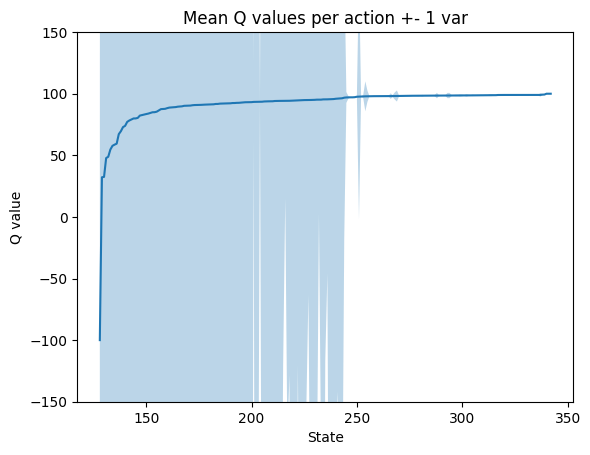

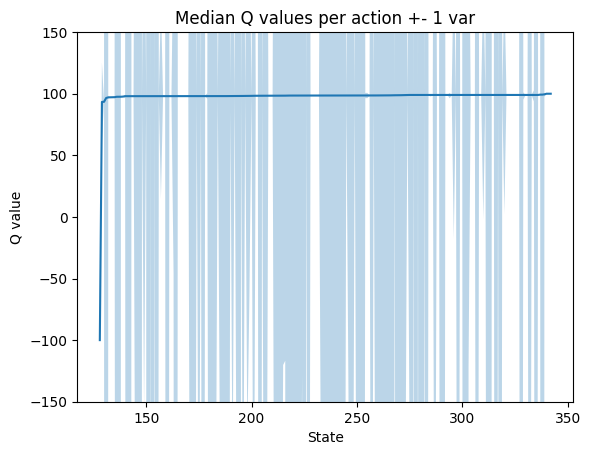

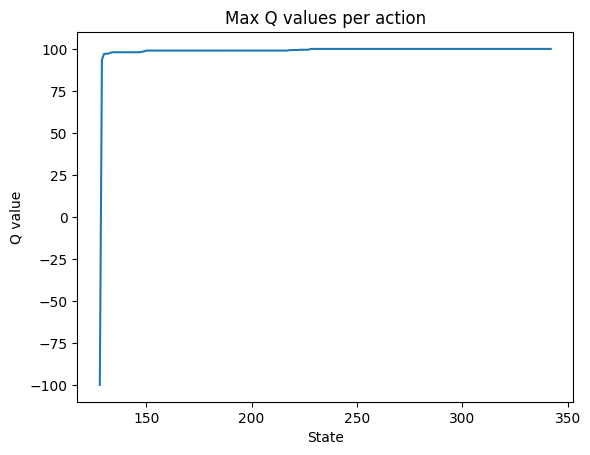

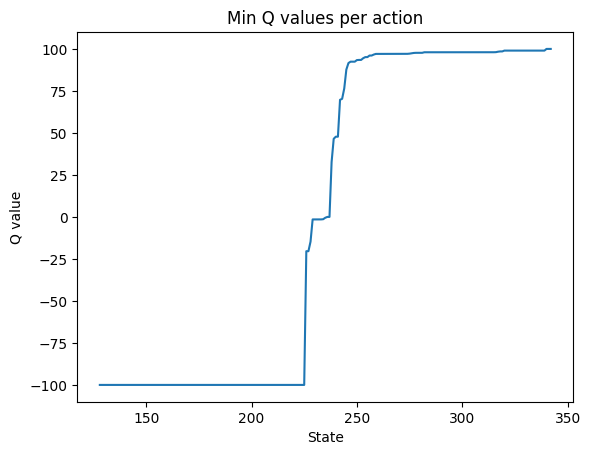

In [74]:
def sortnan(x, index):
    return float('-inf') if np.isnan(x[index]) else x[index]

q_vars = np.nanvar(q_mcp_nan, axis=0)
q_means = np.nanmean(q_mcp_nan, axis=0)
q_medians = np.nanmedian(q_mcp_nan, axis=0)
q_maxs = np.nanmax(q_mcp_nan, axis=0)
q_mins = np.nanmin(q_mcp_nan, axis=0)
stacked = np.column_stack((q_means, q_medians, q_maxs, q_mins, q_vars))
xs = range(7**3)
means_sorted = np.array(sorted(stacked, key=lambda x: sortnan(x, 0)))
means_upper = means_sorted[:, 0] + means_sorted[:, -1]
means_lower = means_sorted[:, 0] - means_sorted[:, -1]
axs = sns.lineplot(x=xs, y=means_sorted[:, 0])
axs.fill_between(x=xs, y1=means_lower, y2=means_upper, alpha=.3)
axs.set_ylim(-150, 150)
plt.xlabel('State')
plt.ylabel('Q value')
plt.title('Mean Q values per action +- 1 var')
plt.show()

medians_sorted = np.array(sorted(stacked, key=lambda x: sortnan(x, 1)))
means_upper = medians_sorted[:, 0] + medians_sorted[:, -1]
means_lower = medians_sorted[:, 0] - medians_sorted[:, -1]
axs = sns.lineplot(x=xs, y=medians_sorted[:, 1])
axs.fill_between(x=xs, y1=means_lower, y2=means_upper, alpha=.3)
axs.set_ylim(-150, 150)
plt.xlabel('State')
plt.ylabel('Q value')
plt.title('Median Q values per action +- 1 var')
plt.show()

maxs_sorted = np.array(sorted(stacked, key=lambda x: sortnan(x, 2)))
axs = sns.lineplot(x=xs, y=maxs_sorted[:, 2])
plt.xlabel('State')
plt.ylabel('Q value')
plt.title('Max Q values per action')
plt.show()

mins_sorted = np.array(sorted(stacked, key=lambda x: sortnan(x, 3)))
axs = sns.lineplot(x=xs, y=mins_sorted[:, 3])
plt.xlabel('State')
plt.ylabel('Q value')
plt.title('Min Q values per action')
plt.show()

In [75]:
behavior_policy_df = (test_set.value_counts(['state', 'action_discrete']) / test_set.value_counts(['state']))
assert (1.0 - behavior_policy_df.groupby('state').sum() < 1e10).all(), "Policy action probs should sum to 1 per state"
behavior_policy_df = behavior_policy_df.reset_index()

In [85]:
# behavior_policy_pivot_temp = behavior_policy_df.reset_index().pivot(columns='action_discrete', index='state')
# print(behavior_policy_pivot_temp.head())
# behavior_policy_df

state  action_discrete
0      170                0.164706
       185                0.105882
       135                0.105882
       184                0.094118
       193                0.070588
                            ...   
649    171                0.009434
       141                0.009434
       121                0.009434
       85                 0.009434
       232                0.009434
Name: count, Length: 15188, dtype: float64

In [89]:
print("Before reset_index: ")
print(behavior_policy_df.head())

behavior_policy_df_reset = behavior_policy_df.reset_index()
print("\nAfter reset_index: ")
print(behavior_policy_df_reset.head())

try:
    behavior_policy_pivot = behavior_policy_df_reset.pivot(columns='action_discrete', index='state')
    print("\nAfter pivot: ")
    print(behavior_policy_pivot.head())
except KeyError as e:
    print(f"\nError during pivot: {e}")
    print("\nColumns available after reset_index: ")
    print(behavior_policy_df_reset.columns)

# If there was an error selecting the column, this will check if 0 exists
if '0' in behavior_policy_pivot.columns:
    print("\nColumn '0' exists in the DataFrame.")
else:
    print("\nColumn '0' does not exist in the DataFrame. Columns available: ")
    print(behavior_policy_pivot.columns)

# This part checks the final DataFrame structure
print("\nFinal structure of behavior_policy_pivot: ")
print(behavior_policy_pivot.info())

Before reset_index: 
state  action_discrete
0      170                0.164706
       185                0.105882
       135                0.105882
       184                0.094118
       193                0.070588
Name: count, dtype: float64

After reset_index: 
   state  action_discrete     count
0      0              170  0.164706
1      0              185  0.105882
2      0              135  0.105882
3      0              184  0.094118
4      0              193  0.070588

After pivot: 
                count                                      ...                \
action_discrete   15  22  23  29  36  37  38  39  43  44   ...       330 331   
state                                                      ...                 
0                 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...       NaN NaN   
1                 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  0.004673 NaN   
2                 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...       NaN NaN   
3                 NaN

In [90]:
# Assuming behavior_policy_pivot is the DataFrame you showed above

# To simplify, let's drop the top level ('count') since it's the same for all columns. This makes the DataFrame single-level.
behavior_policy_pivot.columns = behavior_policy_pivot.columns.droplevel(0)

# Now, your DataFrame has a simple single-level column index with action numbers.
# You can verify the structure
print(behavior_policy_pivot.columns)

# From here, you can proceed with filling missing actions, normalizing, etc.
# Example: Check if an action is missing and fill it with NaN or uniform probability as needed
expected_actions = set(range(1, 7**3 + 1))  # Adjust according to your actual range of actions
current_actions = set(behavior_policy_pivot.columns)
missing_actions = expected_actions - current_actions

# Fill missing actions with NaN (or with uniform probabilities as per your use case)
for action in missing_actions:
    behavior_policy_pivot[action] = np.nan  # or your default value

# Ensure all states have probabilities for all actions, filling missing values as needed
# Your code for normalizing probabilities and handling missing values will go here

# Finally, you can work on converting NaNs to zeros or normalizing the probabilities

Index([ 15,  22,  23,  29,  36,  37,  38,  39,  43,  44,
       ...
       330, 331, 332, 333, 336, 337, 338, 339, 340, 342],
      dtype='int64', name='action_discrete', length=215)


C:\Users\hmilab\AppData\Local\Temp\ipykernel_15500\1383482888.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  behavior_policy_pivot[action] = np.nan  # or your default value
C:\Users\hmilab\AppData\Local\Temp\ipykernel_15500\1383482888.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  behavior_policy_pivot[action] = np.nan  # or your default value
C:\Users\hmilab\AppData\Local\Temp\ipykernel_15500\1383482888.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` m

In [88]:
behavior_policy_df = train_set.value_counts(['state', 'action_discrete']) / train_set.value_counts(['state'])
assert (1.0 - behavior_policy_df.groupby('state').sum() < 1e10).all(), "Policy action probs should sum to 1 per state"

behavior_policy_pivot = behavior_policy_df.reset_index().pivot(columns='action_discrete', index='state')[0]
behavior_policy_states = set(behavior_policy_pivot.index.unique())
for s in range(n_states):
    if s not in behavior_policy_states:
        action_probs = [1.0 / (7**3),] * 7**3 # uniform distribution
        for i, p in enumerate(action_probs):
            behavior_policy_pivot.loc[s] = [s, i, p]

behavior_policy_pivot = behavior_policy_pivot.sort_values(['state'])

for a in range(7**3):
    if a not in behavior_policy_pivot.columns:
        behavior_policy_pivot.loc[:, a] = np.nan

behavior_policy_nan = behavior_policy_pivot[range(7**3)].to_numpy()
assert (1- (np.nansum(behavior_policy_nan, axis=1)) < 1e10).all(), "Policy action probs should sum to 1 per state"
behavior_policy = np.nan_to_num(behavior_policy_nan, 0.0)
assert (1- (behavior_policy.sum(axis=1)) < 1e10).all(), "Policy action probs should sum to 1 per state"
assert behavior_policy.shape == (n_states, 7**3), "Behavior policy should cover all states and actions"
mcp_greedy_mask = mcp_greedy.astype(bool)
assert (mcp_greedy_mask.sum(axis=1) == 1).all(), "Greedy policy mask should mask out all-but-one action"
if UNSAFETY_PROB == 1.0:
    joblib.dump(behavior_policy, "models/clinicians_policy_train_{}.bin".format(seed), compress=True)


KeyError: 0

In [81]:
# from chatGPT taking place of above
# Assuming 'train_set' is your DataFrame and 'n_states' is defined.
# Replace 'max_number_of_states' and 'seed' with appropriate values.
# n_states = max_number_of_states  # Define the total number of states based on your context
n_actions = 7**3  # The total number of actions, based on your formula

# Calculating behavior policy
behavior_policy_df = train_set.value_counts(['state', 'action_discrete']).divide(train_set['state'].value_counts(), axis=0, level='state')
assert (1.0 - behavior_policy_df.groupby('state').sum() < 1e-10).all(), "Policy action probs should sum to 1 per state"

# Correct pivoting and ensuring all states and actions are represented
behavior_policy_pivot_temp = behavior_policy_df.reset_index().pivot(index='state', columns='action_discrete', values=0)  # Replace 0 with the proper column name if needed
all_states = pd.Index(range(n_states), name='state')
all_actions = pd.Index(range(n_actions), name='action_discrete')
behavior_policy_pivot = behavior_policy_pivot_temp.reindex(index=all_states, columns=all_actions, fill_value=0.0)

# Normalizing probabilities to ensure they sum up to 1 for each state
behavior_policy_normalized = behavior_policy_pivot.div(behavior_policy_pivot.sum(axis=1), axis=0)
behavior_policy_normalized.fillna(1.0 / n_actions, inplace=True)  # For states with no actions, use uniform distribution

# Converting to numpy array for further operations or model input
behavior_policy = behavior_policy_normalized.to_numpy()
assert (1- np.sum(behavior_policy, axis=1) < 1e-10).all(), "Policy action probs should sum to 1 per state"
assert behavior_policy.shape == (n_states, n_actions), "Behavior policy should cover all states and actions"

# Additional checks for greedy policy mask, if applicable
# Replace 'mcp_greedy' with your actual greedy policy matrix
# mcp_greedy_mask = mcp_greedy.astype(bool)
# assert (mcp_greedy_mask.sum(axis=1) == 1).all(), "Greedy policy mask should mask out all-but-one action"

# Saving the policy, adjust UNSAFETY_PROB and 'seed' as necessary
UNSAFETY_PROB = 1.0  # Define or adjust as per your context
# seed = 12  # Replace with your actual seed value
if UNSAFETY_PROB == 1.0:
    joblib.dump(behavior_policy, f"models/clinicians_policy_train_{seed}.bin", compress=True)

KeyError: 0

In [ ]:
behavior_policy_df = test_set.value_counts(['state', 'action_discrete']) / test_set.value_counts(['state'])
assert (1.0 - behavior_policy_df.groupby('state').sum() < 1e10).all(), "Policy action probs should sum to 1 per state"

behavior_policy_pivot = behavior_policy_df.reset_index().pivot(columns='action_discrete', index='state')[0]

for a in range(7**3):
    if a not in behavior_policy_pivot.columns:
        behavior_policy_pivot.loc[:, a] = np.nan
behavior_policy_states = set(behavior_policy_pivot.index.unique())
for s in range(n_states):
    if s not in behavior_policy_states:
        action_probs = [1.0 / (7**3),] * 7**3 # uniform distribution
        for i, p in enumerate(action_probs):
            behavior_policy_pivot.loc[s] = [1/(7**3),]*(7**3)

behavior_policy_pivot = behavior_policy_pivot.sort_values(['state'])

behavior_policy_nan = behavior_policy_pivot[range(7**3)].to_numpy()
assert (1- (np.nansum(behavior_policy_nan, axis=1)) < 1e10).all(), "Policy action probs should sum to 1 per state"
behavior_policy = np.nan_to_num(behavior_policy_nan, 0.0)
assert (1- (behavior_policy.sum(axis=1)) < 1e10).all(), "Policy action probs should sum to 1 per state"
assert behavior_policy.shape == (n_states, 7**3), "Behavior policy should cover all states and actions"
mcp_greedy_mask = mcp_greedy.astype(bool)
assert (mcp_greedy_mask.sum(axis=1) == 1).all(), "Greedy policy mask should mask out all-but-one action"
if UNSAFETY_PROB == 1.0:
    joblib.dump(behavior_policy, "models/clinicians_policy_test_{}.bin".format(seed), compress=True)

In [ ]:
behavior_policy

In [ ]:
train_test = pd.concat([train_set, test_set])
behavior_policy_df = train_test.value_counts(['state', 'action_discrete']) / train_test.value_counts(['state'])
assert (1.0 - behavior_policy_df.groupby('state').sum() < 1e10).all(), "Policy action probs should sum to 1 per state"

behavior_policy_pivot = behavior_policy_df.reset_index().pivot(columns='action_discrete', index='state')[0]
for a in range(7**3):
    if a not in behavior_policy_pivot.columns:
        behavior_policy_pivot.loc[:, a] = np.nan

behavior_policy_nan = behavior_policy_pivot[range(7**3)].to_numpy()
assert (1- (np.nansum(behavior_policy_nan, axis=1)) < 1e10).all(), "Policy action probs should sum to 1 per state"
behavior_policy = np.nan_to_num(behavior_policy_nan, 0.0)
assert (1- (behavior_policy.sum(axis=1)) < 1e10).all(), "Policy action probs should sum to 1 per state"
assert behavior_policy.shape == (n_states, 7**3), "Behavior policy should cover all states and actions"
mcp_greedy_mask = mcp_greedy.astype(bool)
assert (mcp_greedy_mask.sum(axis=1) == 1).all(), "Greedy policy mask should mask out all-but-one action"
if UNSAFETY_PROB == 1.0:
    joblib.dump(behavior_policy, "models/clinicians_policy_train_test_{}.bin".format(seed), compress=True)


In [ ]:
import scipy
scipy.stats.entropy(behavior_policy.ravel())

In [ ]:
sns.histplot(scipy.stats.entropy(behavior_policy, axis=1))
plt.title('Behavior policy per-state entropy')
plt.xlabel('Entropy') 
plt.show()

In [ ]:
sns.histplot(scipy.stats.entropy(mcp_softmax, axis=1))
plt.title('Softmax policy per-state entropy')
plt.xlabel('Entropy')
plt.show()

In [ ]:
print("Behavior policy argmax and greedy policy agreement: {}".format((behavior_policy.argmax(axis=1) == mcp_greedy.argmax(axis=1)).sum() / n_states))
sns.histplot(behavior_policy[mcp_greedy_mask], log_scale=(False, True))
plt.xlabel('Action probability greedy policy in behavior policy')
behavior_policy[mcp_greedy_mask].min(), behavior_policy[mcp_greedy_mask].max()

In [ ]:
evaluation_policy = mcp_greedy

behavior_policy_ranks = np.flip(behavior_policy.argsort(axis=1), axis=1)
ep_bp_ranks = []
for s in range(n_states):
    ep_a = evaluation_policy[s,:].argmax()
    bp_rank = np.where(behavior_policy_ranks[s, :] == ep_a)[0][0]
    ep_bp_ranks.append(bp_rank)

sns.histplot(ep_bp_ranks, bins=60)
plt.title('Greedy policy action ranks in behavior policy')
plt.xlabel('Rank')
plt.show()

behavior_policy_ranked_probs = np.flip(np.sort(behavior_policy, axis=1), axis=1)
ep_bp_prob_mass = []
for s in range(n_states):
    ep_a = evaluation_policy[s,:].argmax()
    bp_rank = np.where(behavior_policy_ranks[s, :] == ep_a)[0][0]
    ep_bp_prob_mass.append(behavior_policy_ranked_probs[s, 0:bp_rank].sum())

sns.histplot(ep_bp_prob_mass)
plt.title('Probability mass up to greedy actduion')
plt.xlabel('Action probs')
plt.show()
np.array(ep_bp_prob_mass).min(), np.array(ep_bp_prob_mass).max()

In [ ]:
# state-values of 

In [ ]:
joblib.dump(mcp_greedy, "models/mcp_greedy_policy_{}_{}_{}.bin".format(seed, shaping_name, UNSAFETY_PROB), compress=True)
joblib.dump(mcp_softmax, "models/mcp_softmax_policy_{}_{}_{}.bin".format(seed, shaping_name, UNSAFETY_PROB), compress=True)


In [ ]:
print('test')

In [ ]:
importlib.reload(safety)